# Used Car Price Case Study

### Project Brief

You have been hired as a data scientist at Discount Motors, a used car dealership in the UK. The dealership is expanding and has hired a large number of junior salespeople. Although promising, these junior employees have difficulties pricing used cars that arrive at the dealership. **Sales have declined 18% in recent months, and management would like your help designing a tool to assist these junior employees.**

To start with, they would like you to work with the Toyota specialist to test your idea(s). They have collected some data from other retailers on the price that a range of Toyota cars were listed at. It is known that cars that are more than £1500 above the estimated price will not sell. The sales team wants to know whether you can make predictions within this range.

You will need to present your findings in two formats:
- You must submit a written report summarising your analysis to your manager. As a data science manager, your manager has a strong technical background and wants to understand what you have done and why. 
- You will then need to share your findings with the head of sales in a 10 minute presentation. The head of sales has no data science background but is familiar with basic data related terminology. 

The data you will use for this analysis can be accessed here: `"data/toyota.csv"`

In [1]:
### Importing and reading the CSV

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('./data/toyota.csv')

## Preview Dataset

__Findings:__
- The dataset has 6738 entries and 9 columns.
- Each of the column is of its logical datatype.
- Confirmed that there aren't any missing values.

In [2]:
df.head()  # Preview the dataframe

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,GT86,2016,16000,Manual,24089,Petrol,265,36.2,2.0
1,GT86,2017,15995,Manual,18615,Petrol,145,36.2,2.0
2,GT86,2015,13998,Manual,27469,Petrol,265,36.2,2.0
3,GT86,2017,18998,Manual,14736,Petrol,150,36.2,2.0
4,GT86,2017,17498,Manual,36284,Petrol,145,36.2,2.0


In [3]:
df.info()  # Review dtype and missing data

### NOTES: 
# - All the dtypes matches well intuitively. str shows up as dtype 'object'
# - No missing values in any of the columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6738 non-null   object 
 1   year          6738 non-null   int64  
 2   price         6738 non-null   int64  
 3   transmission  6738 non-null   object 
 4   mileage       6738 non-null   int64  
 5   fuelType      6738 non-null   object 
 6   tax           6738 non-null   int64  
 7   mpg           6738 non-null   float64
 8   engineSize    6738 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 473.9+ KB


In [4]:
df.isna().sum(axis=0)  # Confirming that indeed no missing values

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

## Cleaning Dataset

### Notes:
- If we have further details such as the specific engine model of each entry, then we would be able to verify the engineSize in a sure fire way. Currently, I am only able to clean up the entries with engineSize of 0.0L, which is illogical.
- Further steps: Look into the whether the mpg information is consistent; is this recorded from usage or pulled from a database based on the vehicle's model number/VIN?


In [5]:
### Trim whitespaces from 'model'
df['model'] = df.model.str.strip()

In [6]:
### Checking if any values is illogical
# for col in df.columns:
#     print(df[col].value_counts().sort_index())

## - There are 6x observations with `engineSize==0`, which does not make sense, unless they are electric vehicle.

In [7]:
### Review `engineSize==0`
mask = (df.engineSize==0)
df[mask]

## None of these cars are electric vehicles, thus impute their engineSize with the average of entries with same `model` and `year`

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
2535,Yaris,2016,12300,Manual,6148,Hybrid,0,86.0,0.0
2545,Yaris,2016,11000,Automatic,39909,Hybrid,0,86.0,0.0
5126,Aygo,2019,9800,Manual,3635,Petrol,150,56.5,0.0
5233,Aygo,2019,8000,Manual,8531,Petrol,145,56.5,0.0
5257,Aygo,2019,8000,Manual,5354,Petrol,145,56.5,0.0
5960,C-HR,2017,14300,Manual,46571,Petrol,145,47.1,0.0


In [8]:
### Impute model=='Yaris' engineSize
## - Toyota Yaris only has one engine trim of 1.5L 
## - [source](https://cars.usnews.com/cars-trucks/toyota/yaris/2014/specs)
mask = (df.model=='Yaris')
df[mask].engineSize.value_counts()  # This is showing the lack of veracity in the data.

### Update all Yaris with 1.5L engineSize
df.loc[mask, 'engineSize'] = 1.5

### Sanity check
assert df.loc[mask, 'engineSize'].value_counts().index == 1.5, 'Some engineSize are not matching still.'

In [9]:
### Impute model=='Aygo' engineSize
## - Toyota Aygo of 2014-2020 models have only one engineSize, 1.0L  
## - [source](https://en.wikipedia.org/wiki/Toyota_Aygo#2018%E2%80%932021)
mask = (df.model=='Aygo')
df[mask].engineSize.value_counts()  # Showing 3 entries with 0.0L engineSize.

### Update all Aygo with 1.0L engineSize
df.loc[mask, 'engineSize'] = 1.0

### Sanity check 
assert df.loc[mask, 'engineSize'].value_counts().index == 1.0, 'Some engineSize are not matching still.'

In [10]:
### Impute model=='C-HR' engineSize
## - Unfortunately the C-HR has multiple engineSize, thus without knowing the 
##   specific engine model of the data entry, we can't tell the engineSize.
mask = (df.model=='C-HR')
df[mask].engineSize.value_counts()

### There is only one entry with 0.0L engineSize, thus we can drop this row.
idx_to_drop = df[(df.model=='C-HR') & (df.engineSize==0.0)].index
if ~np.isnan(idx_to_drop):
    df = df.drop(idx_to_drop)  # Drop the single entry with engineSize==0.0
    
### Sanity check
assert (0.0 not in (df.loc[mask, 'engineSize'].value_counts().index)), 'There are still engineSize=0.0 in the data.'

## EDA


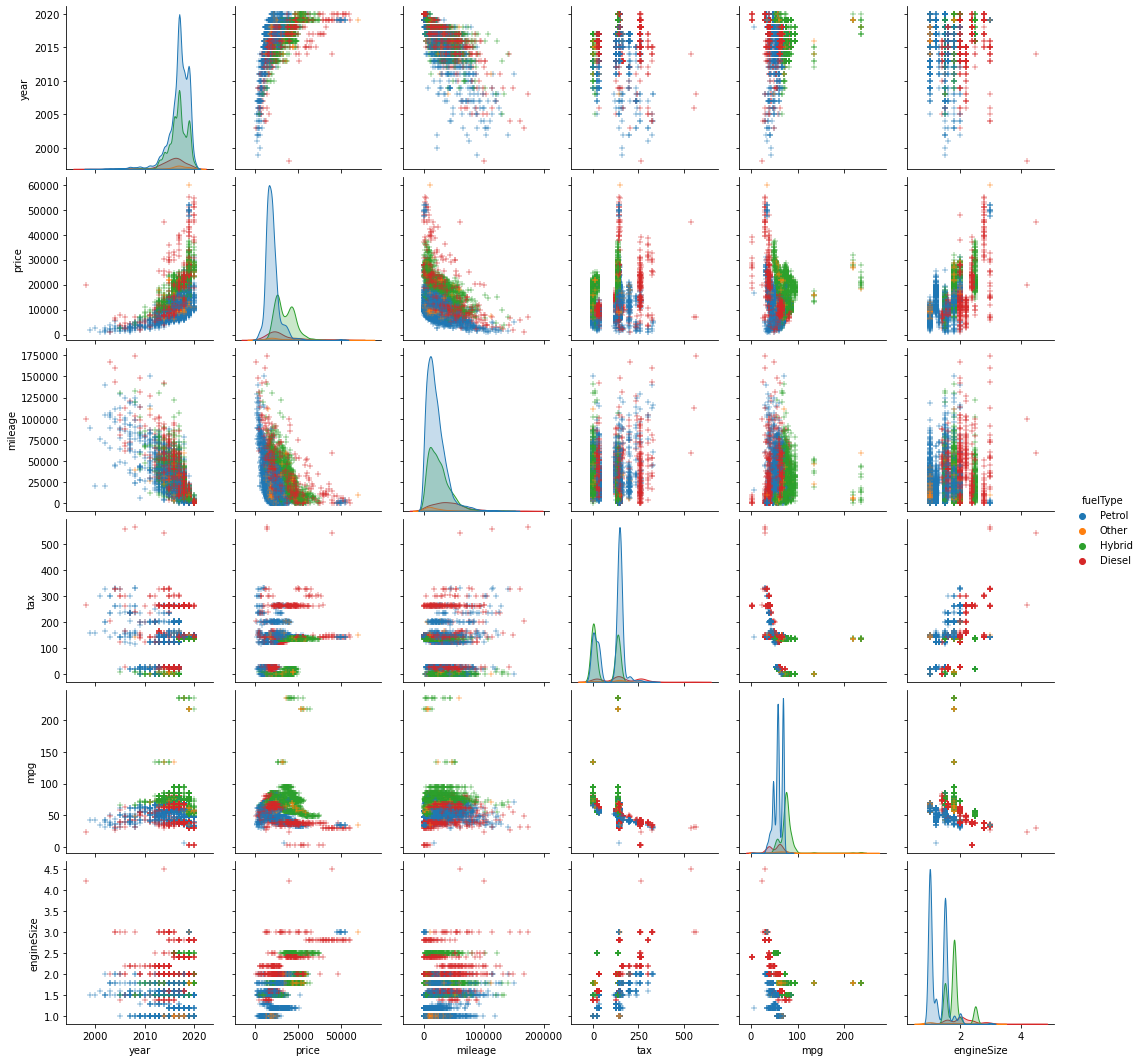

In [11]:
## Libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(df, diag_kind='kde', markers='+', hue='fuelType')
plt.show()

__Pairplot Observations:__
- year:
    - year v year:
        - Petrol (blue) has the most record in the dataset.
        - Hybrid (green) has the second most recrods.
        - Both Petrol and Hybrid have a bimodal like increase after the mode.  >>> ??? 
    - year v price: 
        - Petrol (blue) have largest spread of year and have on average lower price then other fuel types.
        - Diesel (red) have some in betweens. >>> [ ] Look further into this.
        - Hybrid (green) has a faster price grow curve than petrol.
        - Top price range, especially in latter years, occupy the higher price range.
        - The last few years has more points along the price range indicating more car inventory across the range with latter year model.
    - year v mileage: 
        - Petrol (blue) has a steeper negative slope thus lower average mileage of all fuel types, then diesel/other, then hybrid.
        - Interesting to see that diesel are mostly between 2015-2020 >>> ???
    - year v tax:
        - Hybrid has the lowest tax average, then petrol, then diesel/other. >>> Why do diesel vehicles result in higher tax? 
        - Tax are in tiered brackets >>> [ ] Look into tax prices, are these percentages?
    - year v mpg:
        - Hybrid seems to have a signficiant improvement in mpg over the years.
        - Petrol have the largest spread of years.
        - Diesel is still within the range of 2015-2020.
    - year v engineSize:
        - Diesel tends to be ones with bigger engineSize
        - ??? What are the hybrids that have engineSizes comparable to diesel?
        - Petrol ahve a large spread between engineSizes and years, however, the max engineSize of Petrol does not surpass Diesel.
    - price v price:
        - Petrol has the largest price range.
        - Hybrid price has a bimodal distribution. >>> ???
        - Diesel price has the lowest average. >>> [ ] Does Diesel still have the lowest price if we compare similar cars? (There may be a lot more luxury cars in the petrol subset.)
    - price v mileage:
        - Petrol car price is less sensitive to mileage compared to diesel and hybrid.
        - Hybrid price is most sensitive to mileage. >>> ??? Is this because of battery replacement cost? What would the cost basis be if we adjust for battery cost?
        - ??? Are "other fuel type" price least sensitive to mileage?
    - price vs tax:
        - Don't see any specific kinds of relationship.
        - Hybrid has a lower average in tax than others. >>> ??? Is this because of subsidies?
    - price v mpg:
        - Have a little positive relationship when looking at fuel type: petrol has the lowest price and lowest mpg, but hybrid has higher price and higher mpg.
    - price v engineSize: 
        - There is an increasing price with increasing engineSize trend.
        - ??? Why does hybrid have higher cost and higher engineSize?
        - Diesel has larger engineSize than petrol without much increase in price.
    - mileage v mileage:
        - Diesel mileage distribution's center is better than others.
        - ??? How come we're not seeing a strong distribution shift for hybrid? >>> ??? Would we see this shift if we were to exclude the high performance cars from the petrol subset?
    - mileage v tax: 
        - Hybrid dominated the lowest tax bracket here and also has a large spread of mileage indicating the regardless of mileage, hybrid have lower taxes.
        - Petrol occupies the midsection of the tax bracket.
        - Diesel occupies the highest section of the tax bracket. >>> Do diesel fuel have lower tax costs? If not why would buyers be more willing to put up with the higher diesel vehicle costs?
    - mileage v engineSize
        - Unlike other features against engineSize, mileage have very similar spreads across each fuel types.
        - Petrol still has the smallest engineSize, then Hybrid, then Diesel. >>> ??? Is it the way engineSize is being accounted for that is resulting in Hybrid engines having larger size than Petrol?
- tax:
    - tax v tax:
        - Bimodal distribution for both Petrol and Hybrid vehicles.
        - ??? Why does does Petrol's bimodal distribution have different size?
    - tax v mpg: 
        - Seems to show the negative correlation between the two.
        - Hybrid vehicles have two tax groups. >>> ??? Why?
    - tax v engineSize:
        - Shows somewhat positive correlation between tax and engineSize.
        - We can see that Diesel vehicles have larger tax and engineSize on average.
- mpg:
    - mpg v mpg: 
        - Multimodal distributions. >>> ??? Why is that there are multimodel distributions?
        - Hybrid vehicles have higher mean than the Petrol vehicles. 
    - mpg v engineSize:
        - Shows a negative correlation between mpg and engineSize.
        - Hybrid has a higher mpg mean than Diesel, and Diesel has higher mpg mean than Petrol.
- engineSize: 
    - engineSize v engineSize: 
        - Multimodal distribution (perhaps because engineSize is by discrete counts of cylinders.)
        - Diesel has the largest average engineSize, then Hybrid, then Petrol.

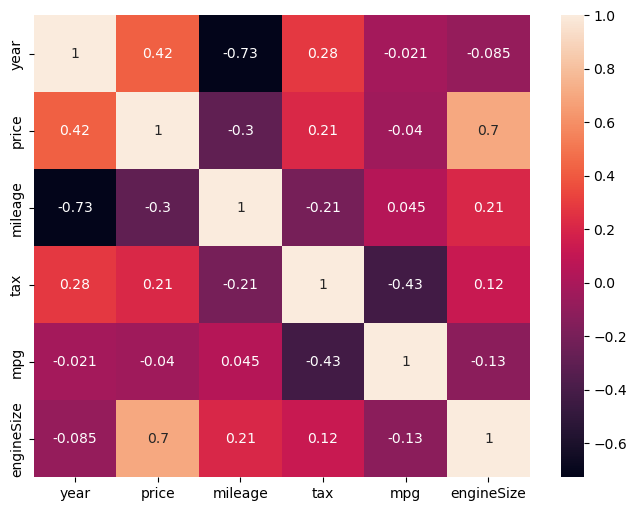

In [12]:
### Correlation heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, ax=ax)
plt.show()  # Show the plot


In [13]:
### Turn correlation matrix from matrix to a long format
corr = df.corr()
mask = np.triu(np.ones(corr.shape)).astype(np.bool)
corr = corr.where(mask)  # Upper corner triangular matrix mask
corr = corr.stack().reset_index()  # Stack to turn the wide matrix to a long dataframe
corr.columns = ['Row', 'Column', 'Correlation']  # Rename columns
corr = corr[corr.Row != corr.Column]  # Remove self correlation
corr = corr.sort_values(by='Correlation', ascending=False)  # Sort by correlation values
display(corr)

/tmp/ipykernel_4166/3064946155.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones(corr.shape)).astype(np.bool)


,Row,Column,Correlation
10,price,engineSize,0.701674
1,year,price,0.420958
3,year,tax,0.283454
8,price,tax,0.214479
14,mileage,engineSize,0.207246
17,tax,engineSize,0.124723
13,mileage,mpg,0.045083
4,year,mpg,-0.020592
9,price,mpg,-0.039872
5,year,engineSize,-0.084572


__Observations of correlation heatmap:__

Correlation ranges between +1 and -1, thus we are interested in both the lightest and darkest colors.

- Lightest colors (positive correlations):
    - engineSize and price correlation = 0.73
    - year and price correlation = 0.42
    - year and tax correlation 0.28
- Darkest colors (negative correlations):
    - year and mileage correlation = -0.73
    - tax and mpg correlation = -0.43
    - price and mileage correlation = -0.30
    
__Notes:__
- tax may be storngly dependent on year.
- price may also be most strongly dependent on year (positive correlation).
- price may also be strongly dependent on mileage (negative correlation).
- price has a stronger correlation with year than with mileage, perhaps 'year' would have more predictive power.
- mileage may be strongly dependent on year; telling me that the average miles per year is a good enough metric.
- tax is strongly dependent on mpg.


In [14]:
### Reviewing the numbers

display(df.describe())  # Numeric features
display(df.describe(include=np.object))  # Object features

,year,price,mileage,tax,mpg,engineSize
count,6737.000000,6737.000000,6737.000000,6737.000000,6737.000000,6737.000000
mean,2016.748107,12522.127208,22853.894018,94.689773,63.044590,1.496853
std,2.204224,6345.451578,19124.700972,73.883717,15.836694,0.426810
min,1998.000000,850.000000,2.000000,0.000000,2.800000,1.000000
25%,2016.000000,8290.000000,9446.000000,0.000000,55.400000,1.000000
50%,2017.000000,10795.000000,18512.000000,135.000000,62.800000,1.500000
75%,2018.000000,14995.000000,31060.000000,145.000000,69.000000,1.800000
max,2020.000000,59995.000000,174419.000000,565.000000,235.000000,4.500000


/tmp/ipykernel_4166/1603344914.py:4: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  display(df.describe(include=np.object))  # Object features


,model,transmission,fuelType
count,6737,6737,6737
unique,18,4,4
top,Yaris,Manual,Petrol
freq,2122,3825,4086


## OHE or Dummify Categorical Variables (`model`, `transmission`, `fuelType`)

In [15]:
df = pd.get_dummies(df, columns=['model', 'transmission', 'fuelType'])  # One Hot Encoding / Dummify
display(df)

,year,price,mileage,tax,mpg,engineSize,model_Auris,model_Avensis,model_Aygo,model_C-HR,...,model_Verso-S,model_Yaris,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,2016,16000,24089,265,36.2,2.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,2017,15995,18615,145,36.2,2.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,2015,13998,27469,265,36.2,2.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,2017,18998,14736,150,36.2,2.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,2017,17498,36284,145,36.2,2.0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6733,2011,5500,30000,20,58.9,1.0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
6734,2011,4985,36154,125,50.4,1.3,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
6735,2012,4995,46000,125,57.6,1.4,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
6736,2011,3995,60700,125,50.4,1.3,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


## Preparing Feature/Target and Train/Test Split

In [16]:
from sklearn.model_selection import train_test_split

## Feature set and Target set 
X = df.loc[:, df.columns!='price']  # Exclude `price`
y = df.loc[:, 'price']

## Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Sanity check
# display(X_train, y_train)

## Checking for curse of dimensionality
print(f"Rows:Columns ratio: {X_train.shape[0] / X_train.shape[1]}")  # There are 173 rows per column, so we should be good 

Rows:Columns ratio: 173.83870967741936


## Feature Selection

## Model #1 - Simple Regression (Multi-Linear, Lasso Regression)

In [17]:
### Linear Regression Fitting
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import r_regression

clf_lr = LinearRegression().fit(X_train, y_train)  # Fit linear regression model

## Train/Test R2 Values
print(f"Linear Regression R2 (train): {clf_lr.score(X_train, y_train)}")
# print(f"Linear Regression R2 (test): {clf_lr.score(X_test, y_test)}")

## Linear Regression Coefficients
# print(f"Linear Regression Coef: {clf_lr.coef_}")
# print(f"Linear Regression abs Coef: {abs(clf_lr.coef_)}")

## Pearson coefficients
pearson_coef = r_regression(X_train, y_train)

## Coalesce into Dataframe
clf_lr_results = pd.DataFrame({'variable':X_train.columns,
                               'linear regression coef': clf_lr.coef_,
                               'linear regression abs coef': abs(clf_lr.coef_),
                               'pearson coef': pearson_coef})
display(clf_lr_results)  # Show the dataframe

## Sort by different values
for col in clf_lr_results.columns:
    sorted_df = clf_lr_results.sort_values(by=col, ascending=False).head(10)
    print(f"Descending sort by '{col}'")
    print(f"Top variables: \n{sorted_df['variable']}")
    display(sorted_df)
    
    
### NOTES:
## - R2 value on the trained set is very high, 0.926
## - Very interesting that car models have strong linear regression weights, 
##   but other car features have strong Pearson correlation coefficient to price.

Linear Regression R2 (train): 0.9317904444521629


,variable,linear regression coef,linear regression abs coef,pearson coef
0,year,8.065565e+02,8.065565e+02,0.414594
1,mileage,-6.372460e-02,6.372460e-02,-0.294305
2,tax,-3.246208e+00,3.246208e+00,0.210244
3,mpg,-7.496740e+00,7.496740e+00,-0.029512
4,engineSize,3.347328e+03,3.347328e+03,0.702151
5,model_Auris,-5.680500e+03,5.680500e+03,0.001550
6,model_Avensis,-4.404585e+03,4.404585e+03,-0.056452
7,model_Aygo,-8.195223e+03,8.195223e+03,-0.463345
8,model_C-HR,-1.859652e+02,1.859652e+02,0.358663
9,model_Camry,7.620678e+02,7.620678e+02,0.097802


Descending sort by 'variable'
Top variables: 
0                       year
26    transmission_Semi-Auto
25        transmission_Other
24       transmission_Manual
23    transmission_Automatic
2                        tax
3                        mpg
22               model_Yaris
21             model_Verso-S
20               model_Verso
Name: variable, dtype: object


,variable,linear regression coef,linear regression abs coef,pearson coef
0,year,8.065565e+02,8.065565e+02,0.414594
26,transmission_Semi-Auto,5.086444e+02,5.086444e+02,0.089099
25,transmission_Other,3.637979e-12,3.637979e-12,0.000000
24,transmission_Manual,-9.030721e+02,9.030721e+02,-0.541638
23,transmission_Automatic,3.944277e+02,3.944277e+02,0.514197
2,tax,-3.246208e+00,3.246208e+00,0.210244
3,mpg,-7.496740e+00,7.496740e+00,-0.029512
22,model_Yaris,-7.444202e+03,7.444202e+03,-0.210080
21,model_Verso-S,-5.121133e+03,5.121133e+03,-0.025176
20,model_Verso,-4.608560e+03,4.608560e+03,-0.008604


Descending sort by 'linear regression coef'
Top variables: 
18               model_Supra
14        model_Land Cruiser
15        model_PROACE VERSO
4                 engineSize
12               model_Hilux
28           fuelType_Hybrid
29            fuelType_Other
0                       year
9                model_Camry
26    transmission_Semi-Auto
Name: variable, dtype: object


,variable,linear regression coef,linear regression abs coef,pearson coef
18,model_Supra,23952.546503,23952.546503,0.270227
14,model_Land Cruiser,15669.977481,15669.977481,0.338552
15,model_PROACE VERSO,6384.876990,6384.876990,0.112096
4,engineSize,3347.328436,3347.328436,0.702151
12,model_Hilux,2211.624519,2211.624519,0.158110
28,fuelType_Hybrid,1244.650684,1244.650684,0.482201
29,fuelType_Other,941.074053,941.074053,0.040588
0,year,806.556508,806.556508,0.414594
9,model_Camry,762.067753,762.067753,0.097802
26,transmission_Semi-Auto,508.644429,508.644429,0.089099


Descending sort by 'linear regression abs coef'
Top variables: 
18            model_Supra
14     model_Land Cruiser
7              model_Aygo
22            model_Yaris
15     model_PROACE VERSO
5             model_Auris
13               model_IQ
19    model_Urban Cruiser
21          model_Verso-S
20            model_Verso
Name: variable, dtype: object


,variable,linear regression coef,linear regression abs coef,pearson coef
18,model_Supra,23952.546503,23952.546503,0.270227
14,model_Land Cruiser,15669.977481,15669.977481,0.338552
7,model_Aygo,-8195.222821,8195.222821,-0.463345
22,model_Yaris,-7444.201780,7444.201780,-0.210080
15,model_PROACE VERSO,6384.876990,6384.876990,0.112096
5,model_Auris,-5680.499941,5680.499941,0.001550
13,model_IQ,-5551.943075,5551.943075,-0.050202
19,model_Urban Cruiser,-5438.621367,5438.621367,-0.033902
21,model_Verso-S,-5121.132990,5121.132990,-0.025176
20,model_Verso,-4608.560192,4608.560192,-0.008604


Descending sort by 'pearson coef'
Top variables: 
4                 engineSize
23    transmission_Automatic
28           fuelType_Hybrid
0                       year
8                 model_C-HR
14        model_Land Cruiser
18               model_Supra
10             model_Corolla
17                model_RAV4
2                        tax
Name: variable, dtype: object


,variable,linear regression coef,linear regression abs coef,pearson coef
4,engineSize,3347.328436,3347.328436,0.702151
23,transmission_Automatic,394.427661,394.427661,0.514197
28,fuelType_Hybrid,1244.650684,1244.650684,0.482201
0,year,806.556508,806.556508,0.414594
8,model_C-HR,-185.965244,185.965244,0.358663
14,model_Land Cruiser,15669.977481,15669.977481,0.338552
18,model_Supra,23952.546503,23952.546503,0.270227
10,model_Corolla,-808.505753,808.505753,0.270050
17,model_RAV4,-1184.963597,1184.963597,0.229558
2,tax,-3.246208,3.246208,0.210244


## Model #2 - Decision Tree regression

In [18]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import RandomizedSearchCV

## Default Decision Tree
clf_dt_default = DecisionTreeRegressor(criterion='squared_error').fit(X_train, y_train)
print(f"Default DT squared_error: {clf_dt_default.score(X_test, y_test)}")
print(f"Default DT parameters: {clf_dt_default.get_params()}")

## Plot the decision tree (may time out)
# plot_tree(clf_dt_default)
# plt.show()


Default DT squared_error: 0.933328202115757
Default DT parameters: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}


## Model #3 - AdaBoost Regression (Decision tree ensemble)

## Model #4 - Random forest regression (Decision tree ensemble)

## Model #5 - SVM (Support Vector Regressor)

In [23]:
### SVM with default hyperparameters
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

## Building an SVR pipeline (SVM needs to normalize inputs)
svr_pipeline = make_pipeline(StandardScaler(), SVR(cv=5))
clf_svr_default = svr_pipeline.fit(X_train, y_train)
print(f"Default SVR score (R2) (train): {clf_svr_default.score(X_train, y_train)}")  # Wow, very bad
print(f"Default SVR score (R2) (test): {clf_svr_default.score(X_test, y_test)}")     # Bad, but better than the train set, why?

Default SVR score (R2) (train): 0.009122131463130345
Default SVR score (R2) (test): 0.0191648325082715


In [31]:
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

param_dist = {'svr__kernel':['linear', 'poly', 'rbf'],
              'svr__degree': range(3, 6), 
              'svr__C': range(1, 5),
              'svr__max_iter': range(5, 10)}
rand_search = RandomizedSearchCV(estimator=clf_svr_default, param_distributions=param_dist, n_iter=5).fit(X_train, y_train)
print(f"Best score (R2) (train): {rand_search.best_score_}")

Best score (R2) (train): -3.3631270083178335


In [29]:
### Feature engineer car sub categories